# <a> Precificação de Aluguéis Indicium </a>

O objetivo do presente projeto consiste na construção de uma estratégia de precificação para aluguéis temporários na cidade de Nova York. Dessa forma, neste trabalho serão constrúidas duas análises, sendo a primeira de natureza diagnóstica e a última de caráter preditivo. 

Na primeira parte do projeto (neste notebook), será desenvolvida uma análise exploratória de dados que vise a estabelecer determinadas hipóteses de negócio, delimitar variáveis importantes para a previsão do preço dos aluguéis, bem como fornecer noções primárias ao conjunto de dados. 

Em segundo plano, um modelo preditivo será construído a fim de auxiliar a Indicium elaborar a estratégia de precificação para o cliente que a contratou. 

In [62]:
# Instalando bibliotecas necessárias
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import prince
from scipy.stats import chi2_contingency
from scipy.stats import pearsonr
import warnings

In [2]:
# Configurando pandas para mostrar todas as linhas e colunas nos DataFrames
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)

# Configurando pandas para não mostrar notação científica 
pd.set_option("display.float_format", lambda x: '%.2f' % x)

# Ignorando possíveis Warnings
warnings.filterwarnings('ignore')

## <a> Dados </a>

Vamos começar lendo a base de dados e, posteriormente, criando um dicionário que represente o significado de cada feature do Data Frame.

In [3]:
# Lendo base de dados
df_precificacao = pd.read_csv("./data/teste_indicium_precificacao.csv")

In [4]:
# Visualizando 5 primeiras linhas do DataFrame
df_precificacao.head()

,id,nome,host_id,host_name,bairro_group,bairro,latitude,longitude,room_type,price,minimo_noites,numero_de_reviews,ultima_review,reviews_por_mes,calculado_host_listings_count,disponibilidade_365
0,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75,-73.98,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
1,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.81,-73.94,Private room,150,3,0,NaN,NaN,1,365
2,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.69,-73.96,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
3,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.80,-73.94,Entire home/apt,80,10,9,2018-11-19,0.10,1,0
4,5099,Large Cozy 1 BR Apartment In Midtown East,7322,Chris,Manhattan,Murray Hill,40.75,-73.97,Entire home/apt,200,3,74,2019-06-22,0.59,1,129


In [5]:
# Checando se a coluna 'id' possui apenas valores únicos 
df_precificacao['id'].is_unique

True

Já que a coluna 'id' possui apenas valores únicos (referentes a cada anúncio nos dados do aplicativo), vamos transformá-la no índice do DataFrame.

In [6]:
# Passando 'id' como indíce do DataFrame
df_precificacao = df_precificacao.set_index("id")

# Visualizando novamente
df_precificacao.head()

,nome,host_id,host_name,bairro_group,bairro,latitude,longitude,room_type,price,minimo_noites,numero_de_reviews,ultima_review,reviews_por_mes,calculado_host_listings_count,disponibilidade_365
id,,,,,,,,,,,,,,,
2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75,-73.98,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.81,-73.94,Private room,150,3,0,NaN,NaN,1,365
3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.69,-73.96,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.80,-73.94,Entire home/apt,80,10,9,2018-11-19,0.10,1,0
5099,Large Cozy 1 BR Apartment In Midtown East,7322,Chris,Manhattan,Murray Hill,40.75,-73.97,Entire home/apt,200,3,74,2019-06-22,0.59,1,129


## <a> Dicionário de Dados </a>

In [7]:
# Criando dicionário de dados
dicionario_dados = dict()

# Preenchendo dicionário de dados
dicionario_dados['nome'] = 'Representa o nome do anúncio'
dicionario_dados['host_id'] = 'Representa o id do usuário que hospedou o anúncio'
dicionario_dados['host_name'] = 'Contém o nome do usuário que hospedou o anúncio'
dicionario_dados['bairro_group'] = 'Contém o nome do bairro onde o anúncio está localizado'
dicionario_dados['bairro'] = 'Contém o nome da área onde o anúncio está localizado'
dicionario_dados['latitude'] = 'Contém a latitude do local'
dicionario_dados['longitude'] = 'Contém a longitude do local'
dicionario_dados['room_type'] = 'Contém o tipo de espaço de cada anúncio'
dicionario_dados['price'] = 'Contém o preço por noite em dólares listado pelo anfitrião'
dicionario_dados['minimo_noites'] = 'Contém o número mínimo de noites que o usuário deve reservar'
dicionario_dados['numero_de_reviews'] = 'Contém o número de comentários dados a cada listagem'
dicionario_dados['ultima_review'] = 'Contém a data da última revisão dada à listagem'
dicionario_dados['reviews_por_mes'] = 'Contém o número de avaliações fornecidas por mês'
dicionario_dados['calculado_host_listings_count'] = 'Contém a quantidade de listagem por host'
dicionario_dados['disponibilidade_365'] = 'Contém o número de dias em que o anúncio está disponível para reserva'

In [8]:
# Ao popular o dicionário de dados com a descrição de cada variável, se torna mais fácil acessar cada significado
dicionario_dados['bairro_group'] # Exemplo com feature 'bairro_group'

'Contém o nome do bairro onde o anúncio está localizado'

## <a> Manipulação de Dados Inicial </a>

In [9]:
# Verificando todas as colunas do DataFrame
df_precificacao.columns

Index(['nome', 'host_id', 'host_name', 'bairro_group', 'bairro', 'latitude',
       'longitude', 'room_type', 'price', 'minimo_noites', 'numero_de_reviews',
       'ultima_review', 'reviews_por_mes', 'calculado_host_listings_count',
       'disponibilidade_365'],
      dtype='object')

In [10]:
# Verificando número de features
df_precificacao.columns.nunique()

15

In [11]:
# Criando função para mostrar dimensões, tipos de dados de cada feature e demais informações do DataFrame
def informacao(dataframe):
    print(f"As dimensões do DataFrame são: {(dataframe.shape[0])} linhas e {(dataframe.shape[1])} colunas")
    print("\n")
    print(f"As features do DataFrame e seus tipos são:\n\n{dataframe.dtypes}")
    print("\n")
    print("Demais informações sobre o DataFrame: \n")
    dataframe.info()

In [12]:
# Chamando função para o DataFrame 'df_precificacao'
informacao(df_precificacao)

As dimensões do DataFrame são: 48894 linhas e 15 colunas


As features do DataFrame e seus tipos são:

nome                              object
host_id                            int64
host_name                         object
bairro_group                      object
bairro                            object
latitude                         float64
longitude                        float64
room_type                         object
price                              int64
minimo_noites                      int64
numero_de_reviews                  int64
ultima_review                     object
reviews_por_mes                  float64
calculado_host_listings_count      int64
disponibilidade_365                int64
dtype: object


Demais informações sobre o DataFrame: 

<class 'pandas.core.frame.DataFrame'>
Index: 48894 entries, 2595 to 36487245
Data columns (total 15 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  ----

> A partir da visualização dos tipos de dados de cada feature do Pandas DataFrame original, é possível ter uma noção de quais variáveis categóricas (object) deveremos codificar para a construção do modelo preditivo. As variáveis 'room_type' e 'bairro_group' são exemplos de variáveis categóricas que podem ser codificadas posteriormente.

Outro ponto a se investigar para codificação de variáveis é a cardinalidade de cada coluna, que pode dar indícios de qual é a melhor abordagem para essa tarefa.

In [13]:
# Checando cardinalidade de cada coluna
df_precificacao.nunique()

nome                             47904
host_id                          37457
host_name                        11452
bairro_group                         5
bairro                             221
latitude                         19048
longitude                        14718
room_type                            3
price                              674
minimo_noites                      109
numero_de_reviews                  394
ultima_review                     1764
reviews_por_mes                    937
calculado_host_listings_count       47
disponibilidade_365                366
dtype: int64

>  Outra informação interessante é referente aos valores não nulos de cada feature. Percebe-se que nas colunas 'nome' e 'host_name' há poucos valores faltantes, enquanto em 'ultima_review' e 'reviews_por_mes' o número de valores faltantes é considerável.

Em razão disso, vamos criar uma função que mostre cada feature do DataFrame e sua correspondente porcentagem de valores faltantes. Isso pode ser bastante útil para analisar qual estratégia de imputação será utilizada (se a imputação de valores for cabível).

In [14]:
# Definindo função para mostrar valores faltantes e calcular percentagem de cada um referente ao total de linhas do DataFrame
def pct_missing(df):
    # Atribuindo array de valores faltantes a variavel 'missing'
    missing = df_precificacao.isnull().sum()
    
    # Mostrando valores faltantes por feature
    print("Esses são os valores faltantes para cada feature: ")
    print("\n") 
    print(missing)
    print("\n") 
    
    # Definindo dicionario 'pct' para armazenar estrutura de chave:valor para nome da feature e porcentagem de missing data
    pct = {}
    
    # List comprehension e loop for para dividir os valores faltantes de cada feature pelo total de linhas para cada feature
    for feature in missing.index:
        pct[feature] = (f"{round((missing[feature] / df_precificacao.shape[0]) * 100, 2)}%")
    print("Essas são as porcentagens de valores faltantes para cada feature: ")
    print("\n")
    
    # Retornando dicionário que mostra cada feature e sua porcentagem de missing data 
    return pct

In [15]:
# Chamando a função para ver valores faltantes e sua porcentagem
pct_missing(df_precificacao)

Esses são os valores faltantes para cada feature: 


nome                                16
host_id                              0
host_name                           21
bairro_group                         0
bairro                               0
latitude                             0
longitude                            0
room_type                            0
price                                0
minimo_noites                        0
numero_de_reviews                    0
ultima_review                    10052
reviews_por_mes                  10052
calculado_host_listings_count        0
disponibilidade_365                  0
dtype: int64


Essas são as porcentagens de valores faltantes para cada feature: 




{'nome': '0.03%',
 'host_id': '0.0%',
 'host_name': '0.04%',
 'bairro_group': '0.0%',
 'bairro': '0.0%',
 'latitude': '0.0%',
 'longitude': '0.0%',
 'room_type': '0.0%',
 'price': '0.0%',
 'minimo_noites': '0.0%',
 'numero_de_reviews': '0.0%',
 'ultima_review': '20.56%',
 'reviews_por_mes': '20.56%',
 'calculado_host_listings_count': '0.0%',
 'disponibilidade_365': '0.0%'}

Levando em consideração as primeiras impressões de nossa base de dados, vamos dar início a uma etapa muito importante em qualquer projeto de Ciência de Dados, a EDA.

## <a> Análise Exploratória de Dados </a>

Além da capacidade investigativa inicial que uma boa EDA proporciona ao Cientista de Dados, a Análise Exploratória de Dados também é importante para propor (e investigar) hipóteses de negócio e introduzir a estratégia de modelagem preditiva que será utilizada. Ao verificar distribuições, medidas de tendência central, separatrizes, frequência e correlação entre as variáveis, pode-se perceber quais são os modelos que obterão melhor desempenho na solução do problema de negócio com que nos deparamos.

Vamos começar a análise com o método describe, selecionando apenas colunas de valores numéricos que sejam relevantes para a modelagem.

In [16]:
# Criando lista das features relevantes
features_relevantes = ['price', 'minimo_noites', 'numero_de_reviews', 
                       'reviews_por_mes', 'calculado_host_listings_count', 'disponibilidade_365']

# Filtrando o describe mostrando apenas as colunas relevantes
(df_precificacao.describe()).loc[:, features_relevantes]

,price,minimo_noites,numero_de_reviews,reviews_por_mes,calculado_host_listings_count,disponibilidade_365
count,48894.00,48894.00,48894.00,38842.00,48894.00,48894.00
mean,152.72,7.03,23.27,1.37,7.14,112.78
std,240.16,20.51,44.55,1.68,32.95,131.62
min,0.00,1.00,0.00,0.01,1.00,0.00
25%,69.00,1.00,1.00,0.19,1.00,0.00
50%,106.00,3.00,5.00,0.72,1.00,45.00
75%,175.00,5.00,24.00,2.02,2.00,227.00
max,10000.00,1250.00,629.00,58.50,327.00,365.00


In [17]:
# Analisando a moda do preço por noite 
df_precificacao['price'].mode()

0    100
Name: price, dtype: int64

In [18]:
# Checando o número de vezes que a variável minimo_noites assume o valor máximo de 1250
df_precificacao.loc[df_precificacao['minimo_noites'] == 1250].shape[0]

1

In [19]:
# Checando o número de aluguéis com menos de 10 reviews
num_10 = df_precificacao.loc[df_precificacao['numero_de_reviews'] < 10].shape[0]
print(num_10)

# Calculando porcentagem de apartamentos com menos de 10 reviews
print(f'{round((num_10/df_precificacao.shape[0]) * 100, 2)}% dos apartamentos possuem menos de 10 reviews')

29519
60.37% dos apartamentos possuem menos de 10 reviews


In [20]:
# Checando o número de aluguéis disponíveis por menos de 10 dias no ano
num_10 = df_precificacao.loc[df_precificacao['disponibilidade_365'] < 10].shape[0]
print(num_10)

# Calculando porcentagem de apartamentos disponíveis por menos de 10 dias no ano
print(f'{round((num_10/df_precificacao.shape[0]) * 100, 2)}% dos apartamentos está disponível por menos de 10 dias no ano')

19980
40.86% dos apartamentos está disponível por menos de 10 dias no ano


Levando em consideração as informações expressas acima, é possível observar que:

* A média do preço por noite dos aluguéis ('price') é maior que sua mediana e sua moda, o que revela uma assimetria à direita na distribuição dessa variável.
* Na variável minimo_noites, relativa ao número mínimo de noites que o usuário deve reservar em determinado aluguel, percebe-se que o valor máximo é de 1250 noites, representando apenas uma observação em todo conjunto de dados.
* O número de reviews geralmente é baixo para os apartamentos. É possível perceber que 50% dos aluguéis possuem menos de 5 reviews e 60,37% deles possui menos de 10 reviews.
* Existem muitos apartamentos que ficam disponíveis para aluguel por pouco tempo no ano. Cerca de 41% dos aluguéis estão disponíveis por menos de 10 dias no ano. 

### <a> Analisando Distribuições - EDA Univariada </a>

Vamos filtrar os outliers na variável price utilizando a seguinte estratégia:

* OUTLIERS PARA BAIXO: 1º Quartil - (1,5 * INTERVALO INTERQUARTÍLICO)

* OUTLIERS PARA CIMA: 3º Quartil + (1,5 * INTERVALO INTERQUARTÍLICO)

In [21]:
# Observando informações do intervalo interquartílico e do primeiro e terceiro quartil
df_precificacao[['price']].describe()

,price
count,48894.00
mean,152.72
std,240.16
min,0.00
25%,69.00
50%,106.00
75%,175.00
max,10000.00


In [22]:
# Calculando outliers para cima
print(f'Os outliers superiores são aqueles acima de {175 + (1.5 * (175 - 69))}')

# Calculando outliers para baixo
print(f'Os outliers inferiores são aqueles abaixo de {69 - (1.5 * (175 -69))}')

Os outliers superiores são aqueles acima de 334.0
Os outliers inferiores são aqueles abaixo de -90.0


Como não existem preços abaixo de 0, vamos considerar apenas os outliers para cima.

Agora, vamos criar uma função que torne mais eficiente o processo de plotar um histograma.

In [23]:
# Criando função para visualização gráfica
def histograma(dados, var, legenda, hue = None):
    '''
    Cria um histograma para visualização da distribuição dos dados
    dados: Pandas DataFrame a ser utilizado
    var: Feature do DataFrame a ser analisada
    legenda: Referente a legenda do eixo x e ao título do gráfico, nessa ordem
    hue: Por default não é utilizado, mas pode ser definido para criar um histograma com uma variável de separação
    '''
    
    sns.set_style("white") # Setando estilo do seaborn 
    plt.figure(figsize=(8,4)) # Definindo tamanho do objeto figure
    sns.histplot(data = dados, x = f'{var}', color = '#FF0000', hue = hue) # Plotando o gráfico
    sns.despine(bottom = True, left = True) # Retirando bordas
    plt.ylabel("Quantidade", color = 'grey', fontsize = 10, labelpad = 15) # Colocando legenda 
    plt.tick_params(axis = 'y', labelsize = 9, color = 'grey') # e ajustando eixo y
    plt.xlabel(f"{legenda[0]}", color = 'grey', fontsize = 10, labelpad = 15) # Colocando legenda 
    plt.tick_params(axis = 'x', labelsize = 9, color = 'grey') # e ajustando o eixo x
    
    # Colocando titulo
    plt.title(f"{legenda[1]}", color = 'k', pad = 20, fontsize = 15, fontweight = 'bold')
    
    # Mostrando 
    plt.show()

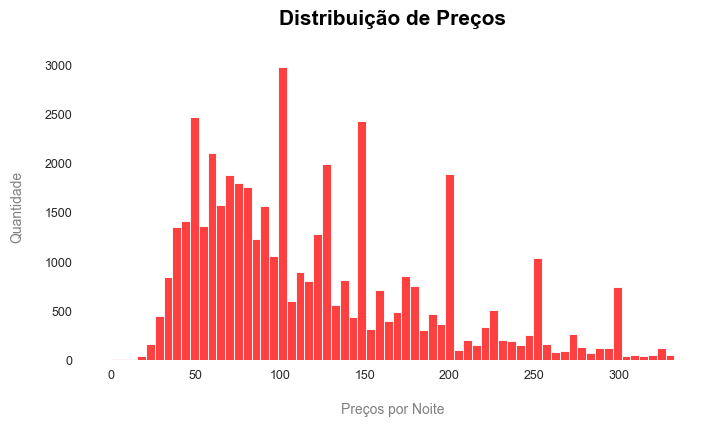

In [24]:
# Chamando a função e eliminando os outliers para uma melhor visualização
histograma(df_precificacao.loc[df_precificacao['price'] < 334], 'price', ('Preços por Noite', 'Distribuição de Preços'))

A partir do gráfico acima percebem-se duas questões relevantes:
1) Nem todos os dados referentes aos preços dos aluguéis estão presentes no histograma acima. A fim de facilitar a visualização os outliers foram calculados e retirados deste gráfico.
   
2) Existe uma intensa concentração dos preços dos aluguéis por noite na faixa de 50 a 150 dólares.

Vamos, agora, analisar a distribuição da disponibilidade ao longo do ano que os imóveis possuem.

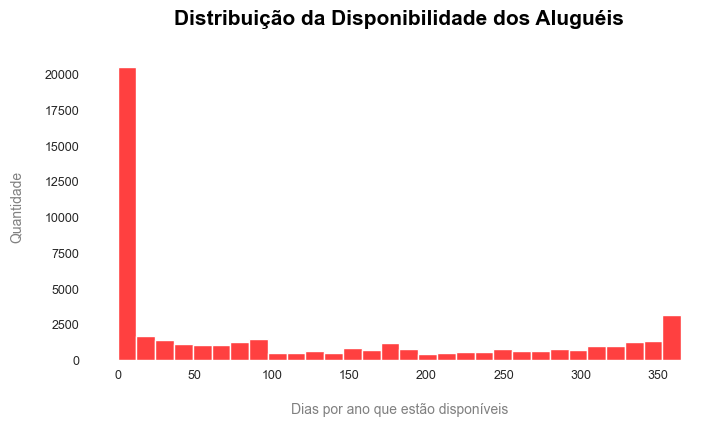

In [25]:
# Chamando função histograma para visualização
histograma(df_precificacao, 'disponibilidade_365', ('Dias por ano que estão disponíveis', 'Distribuição da Disponibilidade dos Aluguéis'))

É interessante perceber que existem mais de 17000 apartamentos que não ficam disponíveis em nenhum dia durante o ano. Isso pode ocorrer em virtude de algum erro na coleta dos dados, ou até mesmo pode indicar que tais apartamentos não estão em condições de serem anunciados para o aluguel. 

Desprendendo-nos dessa discussão, vamos analisar como a distribuição da disponibilidade dos aluguéis se dá, retirando os apartamentos que nunca ficam disponíveis no ano.

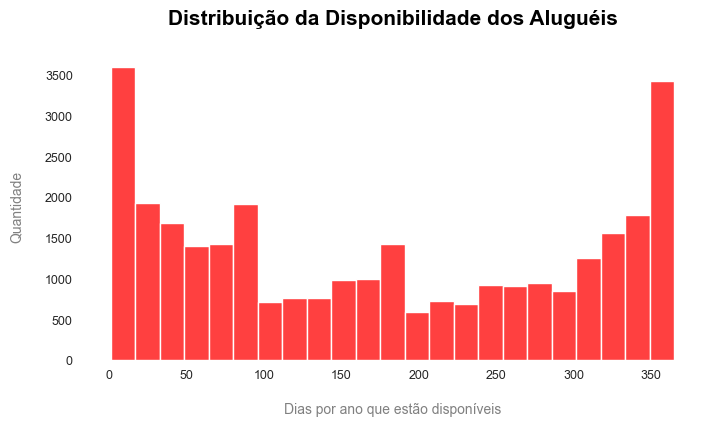

In [26]:
# Chamando função ignorando os apartamentos que nunca ficam disponíveis no ano
histograma(df_precificacao.loc[df_precificacao['disponibilidade_365']>0], 'disponibilidade_365', ('Dias por ano que estão disponíveis', 'Distribuição da Disponibilidade dos Aluguéis'))

In [27]:
# Observando os dias por ano que os aluguéis estão disponíveis
df_precificacao['disponibilidade_365'].value_counts().sort_values(ascending= False).head()

disponibilidade_365
0      17533
365     1294
364      491
1        408
89       361
Name: count, dtype: int64

De acordo com as informações do gráfico, e, valendo-se do método value_counts do pandas, percebe-se que existem muitos apartamentos que ficam disponíveis durante todo o ano, e, também, um substancial número que fica disponível apenas um dia no ano. 

### <a> Analisando Relações entre as Variáveis </a>

Agora vamos analisar como é a faixa de preço dos aluguéis para cada bairro. Esse tipo de informação permite grandes descobertas e pode ser muito relevante para a formulação de hipóteses de negócio.

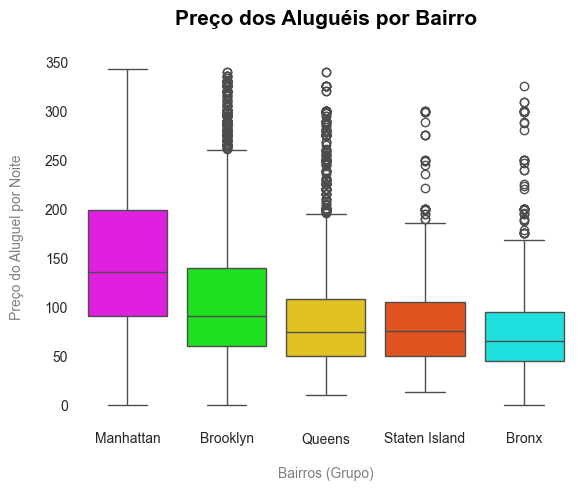

In [28]:
# Analisando a relação do preço dos aluguéis por bairro 
paleta = ['#FF00FF', '#00FF00', '#FFD700', '#FF4500', '#00FFFF'] # Definindo paleta de cores
sns.set_style("white") # Definindo fundo branco para o gráfico

# Plotando gráfico (com outliers fora)
sns.boxplot(data = df_precificacao.loc[df_precificacao['price'] < 344], x = 'bairro_group', y = 'price', palette = paleta)
plt.ylabel("Preço do Aluguel por Noite", color = 'grey', fontsize = 10, labelpad = 15) # Definindo legendas eixo y
plt.xlabel("Bairros (Grupo)", color = 'grey', fontsize = 10, labelpad = 15)  # Definindo legendas eixo x
plt.title("Preço dos Aluguéis por Bairro", color = 'k', pad = 20, fontsize = 15, fontweight = 'bold') # Definindo título
sns.despine(bottom = True, left = True) # Retirando bordas
plt.show()

* Como é possível identificar, geralmente os aluguéis em Manhattan são mais caros que as demais localidades. É interessante perceber que a mediana do preço dos aluguéis nesse bairro é superior em relação a mediana dos demais bairros. 

* Em contrapartida, os aluguéis no Bronx aparentam ser os mais baratos. 

> Diante dessas informações é válido formular a seguinte hipótese de negócio:
> O local do imóvel a ser alugado tem impacto sobre o preço deste.

> Para verificar essa hipótese, é necessário recorrer a um teste estatístico, o teste de comparação de médias.
> A fim de realizar esse teste, primeiro é importante verificar a Normalidade e a Variância dos dados.

> No entanto, verificaremos essa hipótese utilizando o teste qui-quadrado, e, para isso, precisamos de duas variáveis categóricas. Portanto, serão feitas algumas manipulações de dados para transformar o preço em faixa de preço. Nesse sentido, o preço se tornará uma variável categórica e será organizado e definido na seguinte escala: Preço Baixo (valor 0), Preço Intermediário (valor 1), Preço Alto (valor 2) e Preço Muito Alto (valor 3).

### <a> Hipótese de Negócio 1: A localidade do imóvel afeta o preço de seu aluguel ?</a>

In [29]:
# Criando cópia do DataFrame original para evitar erros
df_copia = df_precificacao.copy()

# Definindo função para discretizar o preço
def categorizar_preco(preco):
    if preco >= 0 and preco < 50:
        return 0
    elif preco >= 50 and preco < 150:
        return 1
    elif preco >= 150 and preco < 300:
        return 2
    else:
        return 3

# Aplicando a função à coluna 'price' para criar a nova coluna 'preco_cat'
df_copia['preco_cat'] = df_precificacao['price'].apply(categorizar_preco)

In [30]:
# Aplicando o teste qui quadrado
tabela_contingencia = pd.crosstab(df_copia['preco_cat'], df_copia['bairro_group'])
chi2, p_value, graus_lib, tabela_conting = chi2_contingency(tabela_contingencia)
print(f"A estatística de teste calculada foi: {chi2}")
print(f"O p-valor calculado foi: {round(p_value, 10)}")

A estatística de teste calculada foi: 5829.95432163958
O p-valor calculado foi: 0.0


Diante das estatísticas calculadas, é importante lembrar as hipóteses do teste qui-quadrado para independência.

>  H0: Não há relações significativas entre as variáveis

>  Ha: Há relações significativas entre as variáveis

Também é importante relembrar que a regra de decisão funciona da seguinte maneira:

> A um nível de significância de 5% (alpha = 0.05), se o p-valor for menor que 0.05, rejeita-se a hipótese nula. Por outro lado, se o p-valor for maior ou igual a 0.05, há evidências para que a hipótese nula não seja rejeitada.


Dessa forma, tendo como base o cálculo da estatística de teste e do p-valor a ela relacionado, é possível identificar que, para um nível de significância de 5%, há evidências suficientes (de acordo com os dados) para rejeitar a hipótese nula. Dessa forma, o teste indica que as variáveis preço e bairro estão relacionadas de tal forma que:

## A localidade do imóvel, de fato, afeta o preço do aluguel.

Agora que a relação entre o preço do aluguel e a localidade do imóvel foi provada por meio do teste qui-quadrado, é possível, a partir da visualização do boxplot, propor outra hipótese de négocio.

### <a> Hipótese de Negócio 2: Os imóveis de Manhattan estão relacionados a preços mais altos ?</a>

O teste qui-quadrado apenas informa que há uma dependência entre as variáveis, mas não é suficiente para dizer quais categorias das variáveis estão relacionadas. 

Nesse sentido, é interessante utilizar a análise de correspondência (ANACOR) a fim de descobrir quais categorias das variáveis estão relacionadas de fato. 

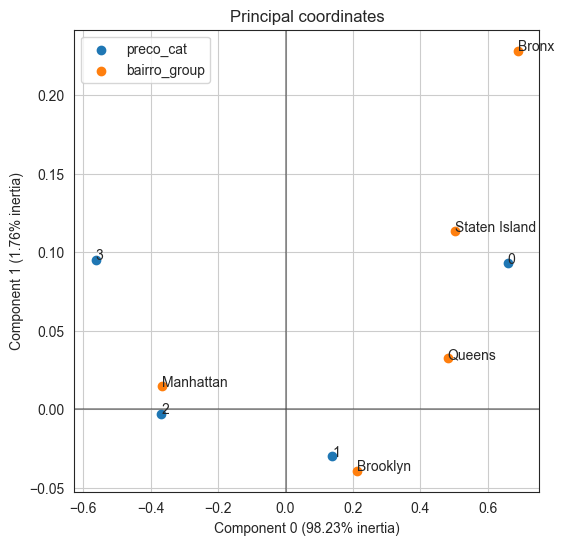

In [31]:
# Criando tabela de contingência
tab = pd.crosstab(df_copia['preco_cat'], df_copia['bairro_group'])

# Criando objeto para Análise de Correlação 
ca = prince.CA(n_components=2)

# Ajustando o objeto com os dados 
ca = ca.fit(tab)

# Mostrando o plot com informações sobre a Análise de Correlação
ca.plot_coordinates(tab)

plt.show()

Observando o gráfico de coordenadas principais, percebe-se que a categoria Manhattan (da variável 'bairro_group') está próxima do valor 2 (preços altos) da varíavel 'preco_cat'. Isso demonstra que a região de Manhattan está relacionada a imóveis de Alto Preço.

Dessa forma, é possível concluir que:

## Os imóveis de Manhattan estão relacionados, de fato, a preços mais altos.

Outro fato que chama bastante atenção é a disposição de imóveis nos grupos de bairros dentro da base de dados. 

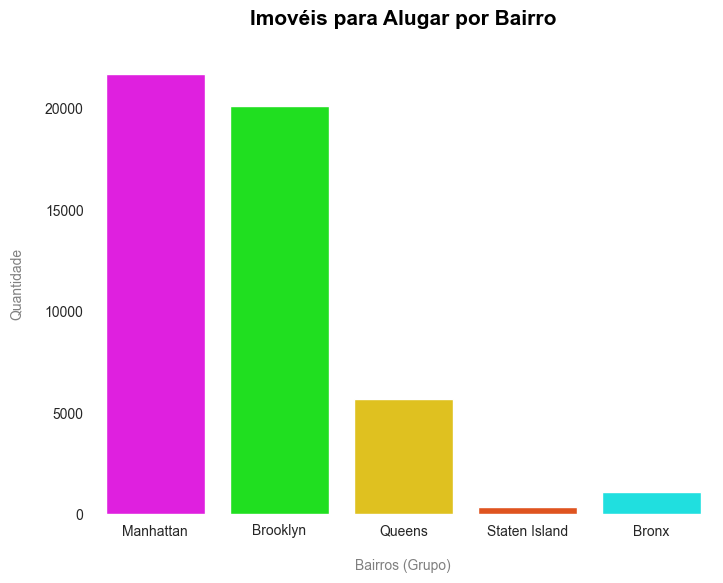

In [32]:
# Setando estilo do seaborn 
sns.set_style("white") 
    
# Definindo tamanho do objeto figure
plt.figure(figsize=(8,6)) 

# Plotando countplot
sns.countplot(data = df_precificacao, x = 'bairro_group', palette = paleta).set_title("Candidatos por tipo de escola")
plt.ylabel("Quantidade", color = 'grey', fontsize = 10, labelpad = 15) # Definindo legendas eixo y
plt.xlabel("Bairros (Grupo)", color = 'grey', fontsize = 10, labelpad = 15)  # Definindo legendas eixo x
plt.title("Imovéis para Alugar por Bairro", color = 'k', pad = 20, fontsize = 15, fontweight = 'bold') # Definindo título
sns.despine(bottom = True, left = True) # Retirando bordas
plt.show()

In [33]:
# Verificando os valores
df_precificacao['bairro_group'].value_counts()

bairro_group
Manhattan        21661
Brooklyn         20103
Queens            5666
Bronx             1091
Staten Island      373
Name: count, dtype: int64

Além da localidade afetar diretamente o preço do aluguel, sobretudo no que se refere a relação de Manhattan com os altos preços, é interessante perceber que existe um volume muito grande de imóveis disponíveis para alugar nesta região.

Outro ponto passível de investigação é a relação do preço com o tipo de imóvel. Se verificarmos que o tipo de imóvel tem relação com o preço do aluguel, teremos uma váriavel candidata a compor nosso modelo de previsão.

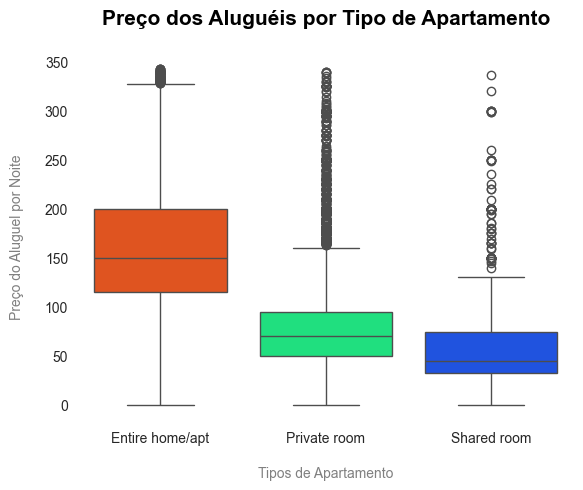

In [34]:
# Analisando a relação do preço dos aluguéis por tipo de apartamento
paleta2 = ['#FF4500', '#00FF7F', '#0044FF']
# Definindo paleta de cores
sns.set_style("white") # Definindo fundo branco para o gráfico

# Plotando gráfico (com outliers fora)
sns.boxplot(data = df_precificacao.loc[df_precificacao['price'] < 344], x = 'room_type', y = 'price', palette = paleta2)
plt.ylabel("Preço do Aluguel por Noite", color = 'grey', fontsize = 10, labelpad = 15) # Definindo legendas eixo y
plt.xlabel("Tipos de Apartamento", color = 'grey', fontsize = 10, labelpad = 15)  # Definindo legendas eixo x
plt.title("Preço dos Aluguéis por Tipo de Apartamento", color = 'k', pad = 20, fontsize = 15, fontweight = 'bold') # Definindo título
sns.despine(bottom = True, left = True) # Retirando bordas
plt.show()

Aqui, percebe-se que parece haver uma relação interessante entre o tipo de apartamento e o preço do aluguel. Os apartamentos 'entire home' (casa inteira) são, geralmente, mais caros. Por outro lado, os apartamentos compartilhados geralmente são os mais baratos. 

Nesse ponto também cabe a hipótese de negócio: O tipo de apartamento impacta o preço de seu aluguel.

Assim como a hipótese da localidade do imóvel, testaremos essa possibilidade com o uso do teste qui-quadrado e da análise de correspondência.

### <a> Hipótese de Negócio 3: O tipo de imóvel (apartamento) impacta o preço de seu aluguel ?</a>

A fim de verificar a validade dessa hipótese de negócio, vamos utilizar o mesmo procedimento anterior: teste qui-quadrado e análise de correspondência.

No entanto, como os dados do preço já foram discretizados, vamos apenas aplicar o teste qui-quadrado para independência de variáveis utilizando a variável 'preco_cat' e 'room_type'.

In [35]:
# Aplicando o teste qui quadrado
tabela_contingencia2 = pd.crosstab(df_copia['preco_cat'], df_copia['room_type'])
chi2_2, p_value, graus_lib, tabela_conting = chi2_contingency(tabela_contingencia2)
print(f"A estatística de teste calculada foi: {chi2_2}")
print(f"O p-valor calculado foi: {round(p_value, 10)}")

A estatística de teste calculada foi: 17724.884967437123
O p-valor calculado foi: 0.0


Como mostrado pelo p-valor e pela estatística de teste calculada, a um nível de significância de 5% podemos rejeitar a hipótese nula de que não há relação entre as variáveis 'preco_cat' e 'room_type'. Dessa forma, conclui-se que:

## O tipo do imóvel, de fato, afeta o preço do aluguel.

Diante deste resultado, é interessante verificar se o tipo de imóvel 'entire home/apt' está realmente relacionado aos aluguéis mais caros. Para isso, utilizaremos a análise de correspondência (ANACOR) novamente.

### <a> Hipótese de Negócio 4: Os imóveis do tipo entire home estão relacionados a aluguéis mais caros ?</a>

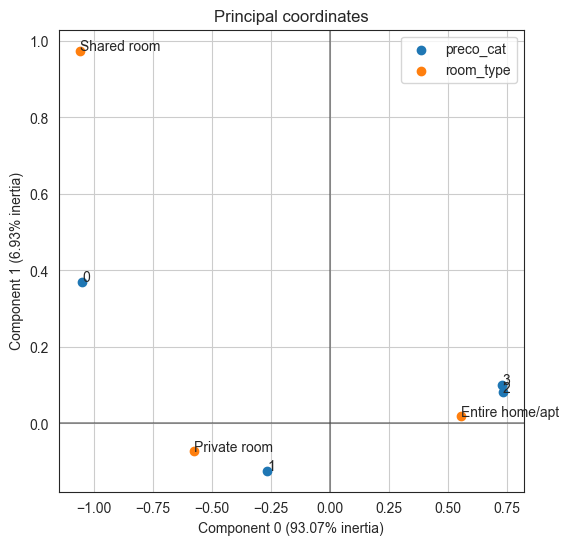

In [36]:
# Criando tabela de contingência
tab2 = pd.crosstab(df_copia['preco_cat'], df_copia['room_type'])

# Criando objeto para Análise de Correlação 
ca2 = prince.CA(n_components=2)

# Ajustando o objeto com os dados 
ca2 = ca2.fit(tab2)

# Mostrando o plot com informações sobre a Análise de Correlação
ca2.plot_coordinates(tab2)

plt.show()

Como é possível identificar, os apartamentos do tipo Entire home estão relacionados aos preços de aluguel altos e muito altos. Dessa forma, pode-se concluir que:

## Os imóveis do tipo Entire Home, de fato, estão relacionados a preços mais altos.

Vamos, agora, analisar a composição dos imóveis disponíveis para aluguel por seu tipo.

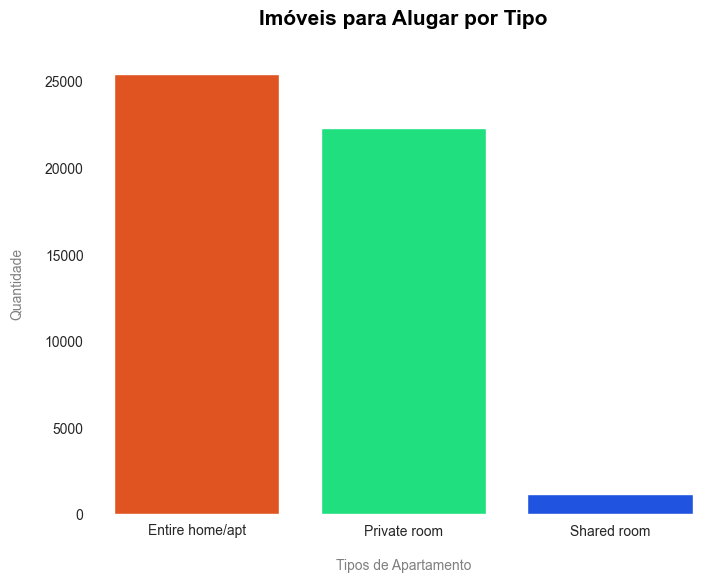

In [37]:
# Setando estilo do seaborn 
sns.set_style("white") 
    
# Definindo tamanho do objeto figure
plt.figure(figsize=(8,6)) 

# Plotando countplot
sns.countplot(data = df_precificacao, x = 'room_type', palette = paleta2)
plt.ylabel("Quantidade", color = 'grey', fontsize = 10, labelpad = 15) # Definindo legendas eixo y
plt.xlabel("Tipos de Apartamento", color = 'grey', fontsize = 10, labelpad = 15)  # Definindo legendas eixo x
plt.title("Imóveis para Alugar por Tipo", color = 'k', pad = 20, fontsize = 15, fontweight = 'bold') # Definindo título
sns.despine(bottom = True, left = True) # Retirando bordas
plt.show()

In [38]:
# Analisando a frequência de tipos de apartamento
df_precificacao['room_type'].value_counts()

room_type
Entire home/apt    25409
Private room       22325
Shared room         1160
Name: count, dtype: int64

Essa informação permite compreender apenas uma parte da composição de tipos de apartamento, uma vez que não mostra a distribuição desses tipos dentro dos grandes bairros. 

Por isso, vamos analisar a composição dos tipos de apartamento para aluguel dentro dos bairros.

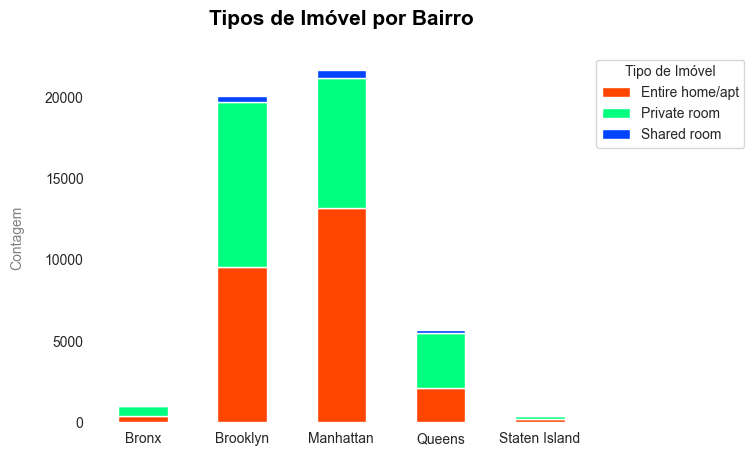

In [39]:
# Contagem de ocorrências dos tipos de apartamento por bairro
contagem = df_precificacao.groupby(['bairro_group', 'room_type']).size().unstack()

# Plotando o stacked barplot
contagem.plot(kind='bar', stacked=True, color=paleta2)

# Exibindo a legenda
plt.legend(title='Tipo de Imóvel', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(bottom = True, left = True) # Retirando bordas
plt.ylabel("Contagem", color = 'grey', fontsize = 10, labelpad = 15) # Definindo legendas eixo y
plt.xlabel("", color = 'grey', fontsize = 10, labelpad = 15)  # Definindo legendas eixo x
plt.title("Tipos de Imóvel por Bairro", color = 'k', pad = 20, fontsize = 15, fontweight = 'bold') # Definindo título
plt.xticks(rotation = 'horizontal') # Girando ticks do eixo x

# Exibindo o gráfico
plt.show()

Manhattan aparece como sendo o bairro com maior número de apartamentos do tipo Entire home, o que é uma das fontes de explicação para o maior nível de aluguel pago nesse bairro, conforme foi comprovado pelos testes estatísticos. 

Agora vamos utilizar os dados de latitude e longitude para visualizar a disposição espacial dos apartamentos nos 5 distritos ('bairro_group') da cidade de Nova York e perceber como o preço dos aluguéis se distribui dentro dessas regiões.

Sendo assim, levando em consideração que existem 5 grandes bairros, é importante tornar o processo de visualização mais eficiente. Para isso, é válida a construção de uma função de visualização.

In [40]:
# Definindo função para plotar gráfico de dispersão de latitude e longitude com ênfase nos preços dos aluguéis
def preco_bairro(bairro):
    '''
    Plota o gráfico de dispersão da localidade dos aluguéis (por bairro) com base em latitude e longitude.
    bairro: String referente ao bairro que se deseja analisar
    '''
    # Separando DataFrame a partir da escolha do bairro. Preços dos aluguéis sempre abaixo de 334 (Valor limite para Outliers)
    df_bairro =  df_precificacao.loc[(df_precificacao['bairro_group'] == bairro) & (df_precificacao['price'] < 334)]
    preco_tirando_outliers = df_bairro['price'] # Armazenando os preços desse bairro no DataFrame preco_tirando_outliers

    # Plotando gráfico de dispersão com base em latitude e longitude (c refere-se ao uma Pandas Series)
    grafico_dispersao = df_bairro.plot.scatter(x = 'longitude', y = 'latitude', c = [preco_tirando_outliers], 
                                              cmap = 'RdYlGn', figsize = (8,6))
    
    # Plotando barra de cores para mostrar a escala
    colorbar = plt.colorbar(grafico_dispersao.collections[0])
    
    # Colocando legenda 'Preço' na barra de cores
    colorbar.ax.text(0.5, 1.06, 'Preço', transform=colorbar.ax.transAxes,
                     va='center', ha='center', fontsize=10, color = 'k')
    
    # Retirando bordas
    sns.despine(bottom = True, left = True)
    
    plt.ylabel("Latitude", color = 'grey', fontsize = 10, labelpad = 15) # Definindo legendas eixo y
    plt.xlabel("Longitude", color = 'grey', fontsize = 10, labelpad = 15)  # Definindo legendas eixo x
    plt.title(f"Preços de Imóveis em {bairro}", color = 'k', pad = 20, fontsize = 15, fontweight = 'bold') # Definindo título

    # Mostrando gráfico
    plt.show()

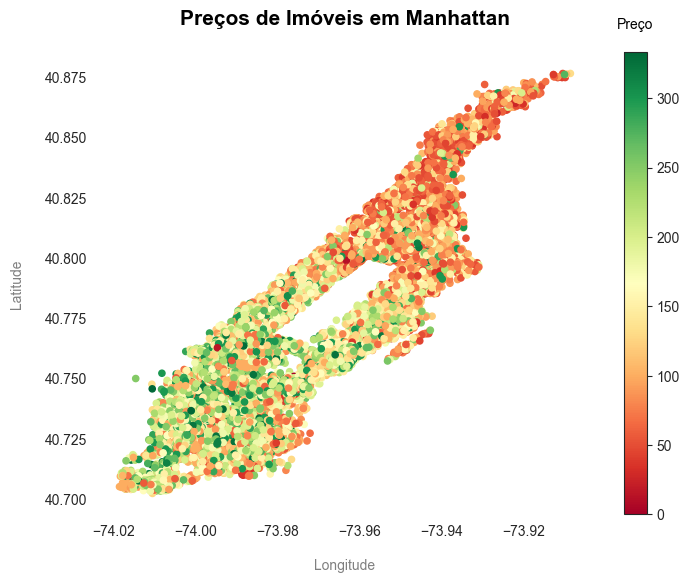

In [41]:
# Analisando a região de Manhattan
preco_bairro('Manhattan')

Nesse gráfico a cor representa o preço dos aluguéis, e, como é possível visualizar, há um certo padrão nos dados. 
Na região sudoeste de Manhattan, os aluguéis são mais caros, o que pode ocorrer em vista das atrações dessa região, como a Times Square e a Estátua da Liberdade. 

É interessante perceber que o formato da região de Manhattan está muito bem definido de acordo com os dados de latitude e longitude (já que dispomos de muitos imóveis nessa região). Um ponto interessante é a presença do Central Park no espaço em branco no meio do gráfico. 

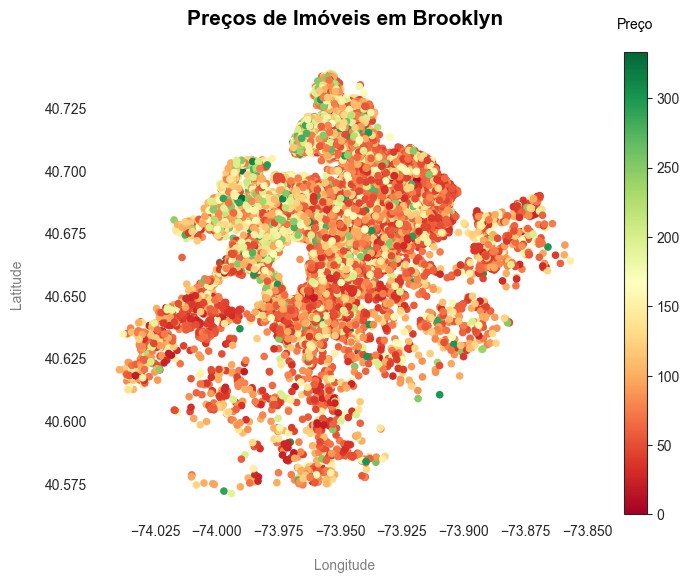

In [42]:
# Analisando a região de Brooklyn
preco_bairro('Brooklyn')

Analisando o Brooklyn, percebe-se que não há um padrão bem definido como em Manhattan. No entanto, é possível observar uma maior incidência de aluguéis mais caros na parte norte da região (que é a parte mais próxima a Manhattan).

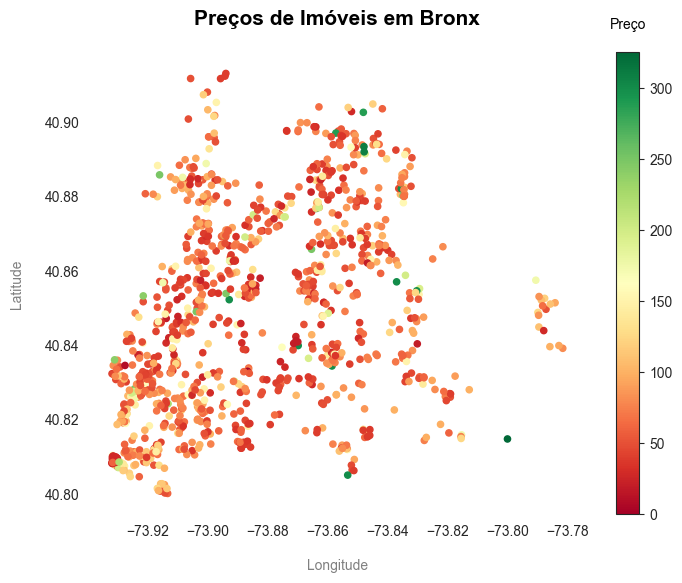

In [43]:
# Analisando a região do Bronx
preco_bairro("Bronx")

No gráfico acima, percebe-se que o formato da região do Bronx não fica muito bem definido. Isso ocorre em razão de um volume de dados relativamente menor, se comparados aos dados das regiões de Manhattan e Brooklyn. 

É possível perceber que não há um padrão de preços claro por partes da região. Apesar disso, é perceptível que, no geral, os aluguéis são os de menor preço.

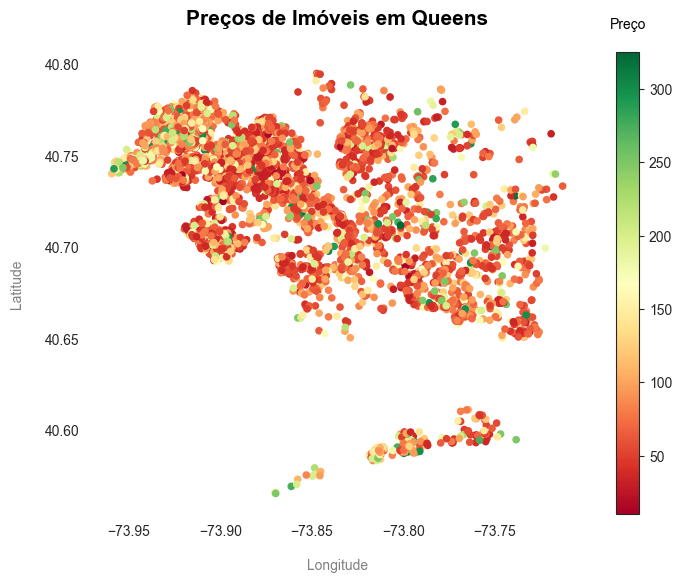

In [44]:
# Analisando a região do Queens
preco_bairro('Queens')

De forma análoga ao discutido na análise do gráfico de dispersão dos preços de aluguéis no Bronx, é possível perceber que não há padrões claros de concentração de apartamentos no Queens, embora, no geral, os aluguéis sejam mais baratos nessa região.

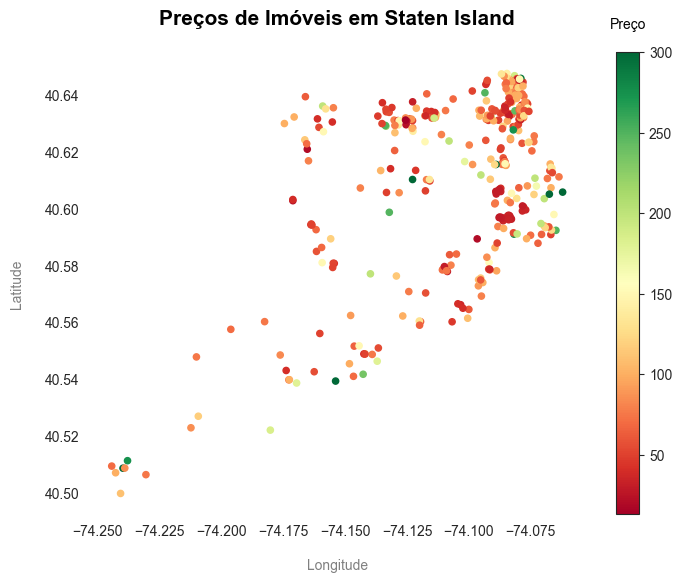

In [45]:
# Analisando a região de Staten Island
preco_bairro("Staten Island")

Por fim, quando analisamos a região de Staten Island, percebe-se que fica mais evidente a falta de definição no formato desse distrito, o que é explicado pela maior carência de dados ocorrer nessa região. 

No que diz respeito ao comportamento dos dados, apesar de, no geral, os aluguéis nessa região serem mais baratos, percebe-se certa concentração destes ao nordeste de Staten Island.

# <a> Perguntas de Negócio </a> 

## <a> A) Supondo que uma pessoa esteja pensando em investir em um apartamento para alugar na plataforma, onde seria mais indicada a compra? </a>

> A fim de responder essa pergunta é interessante relembrar os resultados obtidos na verificação das Hipóteses de Negócio 1 e 2.
Como foi demonstrado anteriormente, existe uma relação significativa entre os preços dos aluguéis por noite com a localidade do imóvel. De forma mais profunda, foi constatado (por meio da utilização da análise de correspondência) que os imóveis localizados em Manhattan geralmente apresentam valores mais altos para o aluguel. Além disso, é importante destacar que, com a utilização do gráfico de dispersão baseado nos dados de latitude e longitude, foi possível observar uma concentração de apartamentos com aluguel mais caro na região sudoeste de Manhattan, possivelmente em virtude dos pontos turísticos dessa localidade, como a Times Square.
Também é válido levar em consideração que os preços dos aluguéis por noite dos imóveis do tipo Entire Home são os mais caros dentre os outros tipos de imóveis. 

> Tendo isso em mente, é possível concluir que a compra de um apartamento é mais vantajosa na **região sudoeste de Manhattan**, onde os preços dos aluguéis são mais **altos**. Além disso, se essa pessoa deseja ampliar ao máximo o rendimento de seu investimento, é **interessante considerar a compra de um apartamento do tipo Entire Home/Apt**.

## <a> B) O número mínimo de noites e a disponibilidade ao longo do ano interferem no preço? </a>

#### Preço x Disponibilidade

> A fim de responder essa questão, vamos primeiro identificar se a disponibilidade ao longo do ano interfere no preço do aluguel por noite. Nesse sentido, é importante perceber que as duas variáveis são numéricas, e, portanto, o teste qui-quadrado não cabe nesse momento. Sendo assim, vamos utilizar a de correlação de Pearson para identificar se a disponibilidade ao longo do ano interfere no preço.
>
> Antes da realização do teste, é válido lembrar as hipóteses do mesmo:

> H0: Não há correlação linear significativa entre as duas variáveis na população.
>
> Ha: Há uma correlação linear significativa entre as duas variáveis na população.

In [86]:
# Utilizando o teste de pearson
correlacao, p_valor = pearsonr(df_precificacao['price'], df_precificacao['disponibilidade_365'])

# Mostrando resultados
print(f"A correlação entre Preço e Disponibilidade é: {correlacao}")
print(f"O p-valor do teste de hipótese é: {p_valor}")

A correlação entre Preço e Disponibilidade é: 0.08183250775771377
O p-valor do teste de hipótese é: 2.0332280495196573e-73


> Levando em consideração um nível de significância de 5% (alpha = 0.05), é possível rejeitar a hipótse nula, de tal forma que o teste indica a presença de uma correlação linear significativa entre as duas variáveis na população.
> 
> Apesar disso, percebe-se que a correlação é positiva, porém fraca (0.08).

* É válido visualizar o gráfico de dispersão dessas duas variáveis:

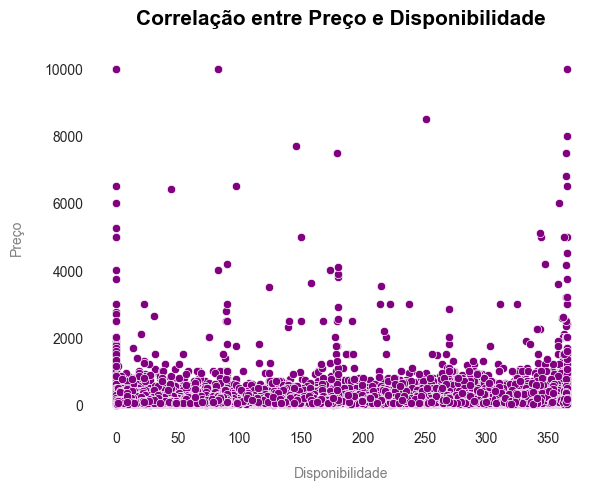

In [92]:
# Plotando gráfico
sns.scatterplot(df_precificacao, x = 'disponibilidade_365', y = 'price', color = 'purple')
sns.despine(bottom = True, left = True) # Retirando bordas    
plt.ylabel("Preço", color = 'grey', fontsize = 10, labelpad = 15) # Definindo legendas eixo y
plt.xlabel("Disponibilidade", color = 'grey', fontsize = 10, labelpad = 15)  # Definindo legendas eixo x
plt.title("Correlação entre Preço e Disponibilidade", color = 'k', pad = 20, # Definindo título
          fontsize = 15, fontweight = 'bold') 
plt.show() # Mostrando o gráfico

> Dessa forma, conclui-se que a **disponibilidade do imóvel para aluguel ao longo do ano de fato interfere no preço do aluguel**. No entanto, essa interferência é ínfima, havendo fatores que possuem maior influência sobre o preço do aluguel (como mostrado na pergunta de negócio A).

#### Preço x Mínimo de Noites

> Levando em consideração o número mínimo de noites que devem ser alugadas e o preço do aluguel, é importante identificar se há correlação entre essas duas variáveis. Sendo assim, como as duas variáveis são numéricas, é possível utilizar o teste de correlação de Pearson novamente. 

In [98]:
# Utilizando o teste de pearson
correlacao2, p_valor2 = pearsonr(df_precificacao['price'], df_precificacao['minimo_noites'])

# Mostrando resultados
print(f"A correlação entre Preço e Mínimo de Noites é: {correlacao2}")
print(f"O p-valor do teste de hipótese é: {p_valor2}")

A correlação entre Preço e Mínimo de Noites é: 0.04279927891945608
O p-valor do teste de hipótese é: 2.8561503545564704e-21


> Levando em consideração um nível de significância de 5% (alpha = 0.05), também é possível rejeitar a hipótese nula, de tal forma que o teste indica a presença de uma correlação linear significativa entre as duas variáveis na população.
> 
> Como ocorreu no teste da relação de preço e disponibilidade, percebe-se que a correlação é positiva, porém fraca. Ainda é importante mencionar que a correlação entre preço e mínimo de noites (0.04) é ligeiramente menor que a correlação analisada no caso anterior (0.08).

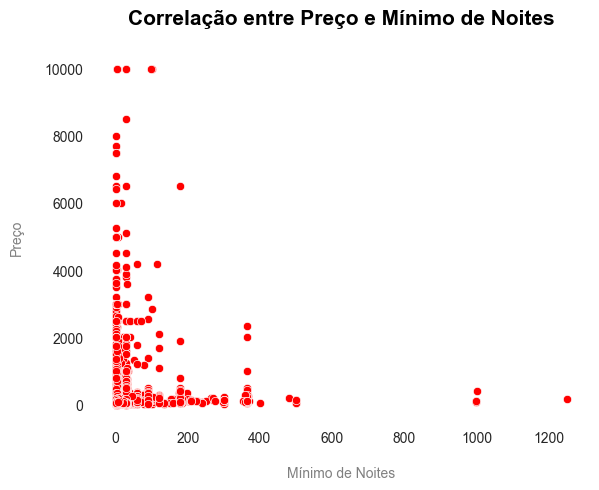

In [100]:
# Plotando gráfico para analisar correlação entre preço e mínimo de noites
sns.scatterplot(df_precificacao, x = 'minimo_noites', y = 'price', color = 'red')
sns.despine(bottom = True, left = True) # Retirando bordas    
plt.ylabel("Preço", color = 'grey', fontsize = 10, labelpad = 15) # Definindo legendas eixo y
plt.xlabel("Mínimo de Noites", color = 'grey', fontsize = 10, labelpad = 15)  # Definindo legendas eixo x
plt.title("Correlação entre Preço e Mínimo de Noites", color = 'k', pad = 20, # Definindo título
          fontsize = 15, fontweight = 'bold') 
plt.show() # Mostrando o gráfico

> Como ocorreu com as variáveis preço e disponibilidade, percebe-se, com auxílio de recursos gráficos (por meio do gráfico de dispersão) que a relação entre as duas variáveis não é facilmente identificável. No entanto, usando o teste de correlação de Pearson, conclui-se que a **o número mínimo de noites para aluguel de fato interfere no preço do mesmo**.
>
> Apesar disso, segue a mesma questão da análise anterior (preço x disponibilidade), isto é, mesmo que o mínimo de noites para aluguel tenha certa influência no preço deste, existem fatores que exercem uma influência muito maior, como a localidade, conforme foi explicitado na pergunta de negócio A.

## <a> C) Existe algum padrão no texto do nome do local para lugares de mais alto valor ?</a>


A fim de responder essa pergunta é interessante, primeiramente, filtrar o DataFrame para que apenas os valores de aluguel mais altos apareçam.

In [169]:
# Filtrando DataFrame para valores de aluguel maiores que 2000
df_precificacao.loc[df_precificacao['price'] > 2000, ['price', 'nome']].head(30)

,price,nome
id,,
363673,3000,Beautiful 3 bedroom in Manhattan
826690,4000,"Sunny, Family-Friendly 2 Bedroom"
893413,2500,Architecturally Stunning Former Synagogue!
1448703,5000,Beautiful 1 Bedroom in Nolita/Soho
2110145,6000,UWS 1BR w/backyard + block from CP
2224896,4000,NYC SuperBowl Wk 5 Bdrs River View
2243699,5250,"SuperBowl Penthouse Loft 3,000 sqft"
2271504,6500,SUPER BOWL Brooklyn Duplex Apt!!
2274084,2750,3 Bedroom Apartment


Observando os nomes dos apartamentos cujo aluguel está listado acima dos 2000 dólares, percebe-se a presença de um certo padrão de nomes. Muitos desses imóveis apresentam descrições envolvendo bairros prestigiados de Nova York, como "Nolita/Soho", "Upper East", "Greenwich Village" e "TriBeCa". Além disso, também é possível identificar que muitos desses nomes apresentam adjetivos chamativos, como "Beautiful", "Luxury", "Stunning" e "Architecturally Stunning". Outro nome que apareceu dentre os aluguéis mais caros é relacionado a eventos esportivos, como é o caso de "SuperBowl".

In [164]:
# Definindo palavras-chave relacionadas a características do imóvel
keywords_caracteristicas = ["Beautiful", "Luxury", "Stunning", "Architecturally Stunning"]

# Definindo palavras-chave relacionadas a localização
keywords_localizacao = ["Nolita/Soho", "Upper East", "Greenwich Village", "TriBeCa"]

# Definindo palavras-chave relacionadas a eventos
keywords_eventos = ["SuperBowl"]

# Função para contar o número de ocorrências de palavras-chave
def contar_ocorrencias(data, keywords):
    '''Conta o número de ocorrências das plavaras-chave de uma base de dados
    data: Base de dados utilizada
    keywords: Palavras-chave a serem contadas'''
    # Usando método str.contains e expressão regular '|'.join(keywords) para contar o número de qualquer uma das keywords
    # case = False desconsidera maiúsculas e minúsculas, na = False desconsidera valores ausentes
    return data['nome'].str.contains('|'.join(keywords), case=False, na=False).sum() 

In [168]:
# Contagem de ocorrências para cada categoria (LEVANDO EM CONSIDERAÇÃO APENAS PREÇOS DE ALUGUEL ACIMA DE 2000)
ocorrencias_caracteristicas = contar_ocorrencias(df_precificacao.loc[df_precificacao['price'] > 2000],
                                                 keywords_caracteristicas) # Contagem de keywords de caracteristicas

ocorrencias_localizacao = contar_ocorrencias(df_precificacao.loc[df_precificacao['price'] > 2000],
                                             keywords_localizacao) # Contagem de keywords de localizacao

ocorrencias_eventos = contar_ocorrencias(df_precificacao.loc[df_precificacao['price'] > 2000],
                                         keywords_eventos) # Contagem de keywords de eventos

# Exibindo os resultados
print(f"Ocorrências de palavras-chave de características: {ocorrencias_caracteristicas}")
print(f"Ocorrências de palavras-chave de localização: {ocorrencias_localizacao}")
print(f"Ocorrências de palavras-chave de eventos: {ocorrencias_eventos}")

Ocorrências de palavras-chave de características: 17
Ocorrências de palavras-chave de localização: 7
Ocorrências de palavras-chave de eventos: 2


É importante levar em consideração que esse filtro não é exato, mas fornece uma compreensão primária dos nomes que geralmente aparecem em apartamentos cujo aluguel tem patamar mais elevado.

Vamos, agora, plotar um gráfico para visualizar a frequência de palavras encontradas na descrição do anúncio dos aluguéis.

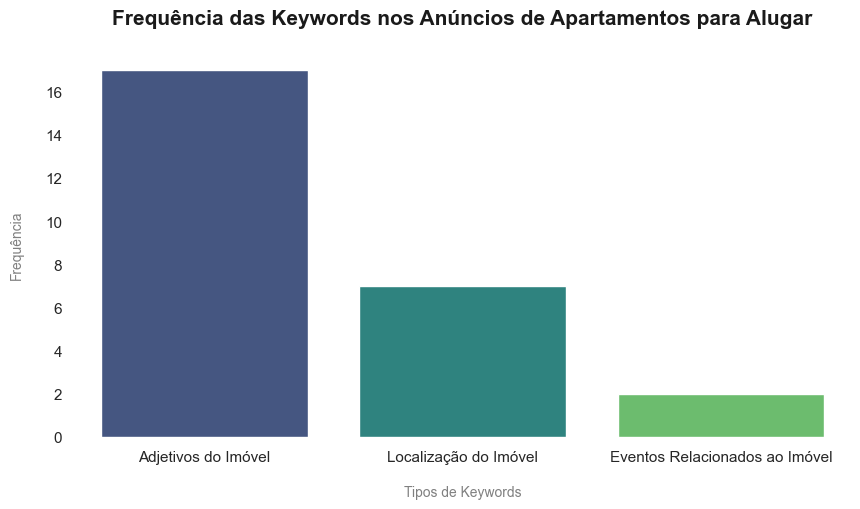

In [183]:
# Criando DataFrame para armazenar valores das ocorrências de Keywords
categorias = ['Adjetivos do Imóvel', 'Localização do Imóvel', 'Eventos Relacionados ao Imóvel']
contagens = [ocorrencias_caracteristicas, ocorrencias_localizacao, ocorrencias_eventos]

# Criar DataFrame para plotar
dados_plot = pd.DataFrame({'Categoria': categorias, 'Contagem': contagens})

# Plotando
plt.figure(figsize=(10, 5)) # Definindo tamanho do objeto figure
sns.set_theme(style="white") # Setando tema do seaborn
sns.barplot(x='Categoria', y='Contagem', data=dados_plot, palette="viridis") # Plotando o gráfico de barras
plt.ylabel("Frequência", color = 'grey', fontsize = 10, labelpad = 15) # Definindo legendas eixo y
plt.xlabel("Tipos de Keywords", color = 'grey', fontsize = 10, labelpad = 15)  # Definindo legendas eixo x
plt.title("Frequência das Keywords nos Anúncios de Apartamentos para Alugar", color = 'k', pad = 20, fontsize = 15,
          fontweight = 'bold') # Definindo título
sns.despine(bottom = True, left = True) # Retirando bordas

# Mostrando gráfico
plt.show()

> Como foi discutido anteriormente, dentre a descrição dos apartamentos disponíveis para aluguel com preço mais elevado, percebe-se que sempre há ênfase em palavras que qualificam o imóvel (Adjetivos do Imóvel), bem como palavras que explicitam a localização do imóvel, sobretudo em bairros prestigiados, e que indicam a presença de eventos relacionados ao imóvel.
>
> Portanto, conclui-se que **o padrão que existe no nome dos anúncios dos apartamentos mais caros representa a referência à qualidade, localização, ou aos eventos relacionados ao imóvel**.

## <a> Conclusões da EDA </a>

* Conforme foi mostrado durante toda a exploração dos dados, se uma pessoa quiser investir na compra de um imóvel para alugar, **é interessante que seja considerada a compra de um apartamento do tipo Entire Home no bairro de Manhattan, e, mais especificamente, na região sudoeste. Além disso, é interessante que o anúncio do aluguel desse apartamento contenha adjetivos do imóvel, bem como a descrição de sua localidade.**
* Dessa forma, é possível tornar o investimento mais rentável, tendo em vista o que os dados apresentaram.